## RDA Quantitative Data Analysis Assessment: 2 ANALYSIS

#### Prompt

The behavioral health department of a medium-sized county has contracted RDA to evaluate their Substance Use Detox Program. The behavioral health department has noticed that clients seem to be staying longer than expected. As a member of this project team, you are tasked with analyzing the data to <b>explore whether certain groups of people are staying in the Substance Use Detox Program longer than expected (i.e., longer than five days).</b>

The client has sent RDA Substance Use Detox Program data for everyone they served in fiscal year 2015-2016. Each row represents a program enrollment, and a person can be enrolled multiple times in the same year. The Substance Use Detox Program data is on the "Detox" tab (i.e., purple tab) of this spreadsheet and the associated data dictionary is on the "Data Dictionary" tab (i.e., blue tab). Fortunately, this client always gets you clean data (yay!) so you don't need to worry about cleaning the data. We would like you to use this dataset to complete the following tasks:

<b>Part I. Please analyze the Substance Use Detox Program data to explore whether certain groups of people are staying in the Substance Use Detox Program longer than expected (i.e., longer than five days).</b>

Part II. Develop a brief PowerPoint (or similar) presentation (no longer than 8-12 minutes of presentation time) for the client that includes an introduction, methods, and summary of key findings and recommendations (including recommended next steps for data collection and analyses). Keep in mind that the client does not have a technical/research background. You may include any graphs or tables you think would be helpful for the client, and you may use any software you are comfortable with for the analysis. 

#### 02/04/2023 at 18:08 CEST
* Read in processed data
* Do exploratory analysis
* Identify key insights

### 0. Preparation

<b> TASK: Explore whether certain groups of people are staying in the Substance Use Detox Program longer than expected (i.e., longer than five days) </b>

In [1]:
# import necessary packages
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style

from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
from plotly import graph_objects as go
from tqdm import tqdm

from lightgbm import LGBMClassifier
import shap
from sklearn.model_selection import cross_val_score

In [2]:
# change working directory to a specified directory
os.chdir('../')
print("Directory Changes")

# Get current working directory
cwd = os.getcwd()
print("Current working directory is:", cwd)

Directory Changes
Current working directory is: C:\Users\Carol\Documents\Work\WorkOpportunities\RDAConsulting\analysis


In [21]:
# read in interim 'data_raw' data
data_raw = pd.read_csv("data/interim/data.csv")

In [22]:
# drop unnecessary columns from 'data_raw' to make new df, 'data' to prepare analysis df
data = data_raw.drop(['age', 'race', 'start_date', 'start_freq', 'exit_date', 'exit_substance', 'exit_freq', 'start_freq_relative', 'exit_freq_relative', 
           'change_freq', 'change_freq_pctpt', 'program_success', 'enrollment_v_target', 'change_substance'], axis = 1)

### 1. Explore Data 

#### 1.1 Explore Data By Demographics Enrolled in Programing

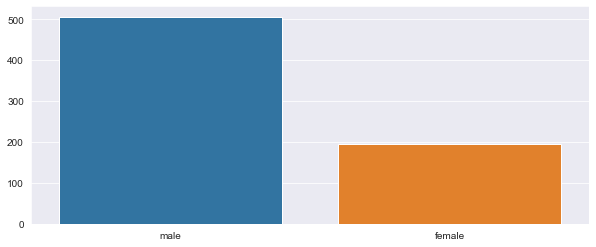

In [5]:
# gender
genders = data_raw.gender.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(10,4))
sns.barplot(x=genders.index, y=genders.values)
plt.show()

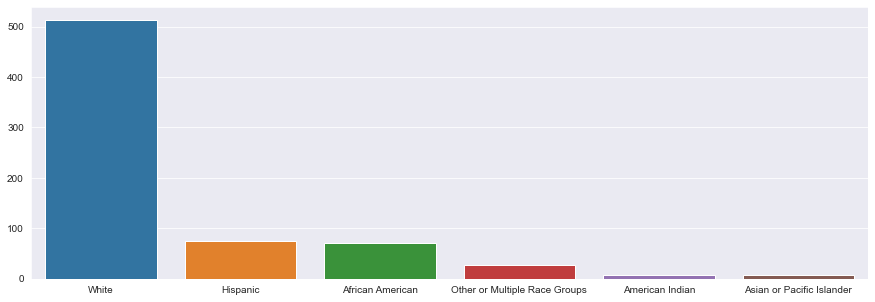

In [6]:
# race
race = data_raw.race.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(15,5))
sns.barplot(x=race.index, y=race.values)
plt.show()

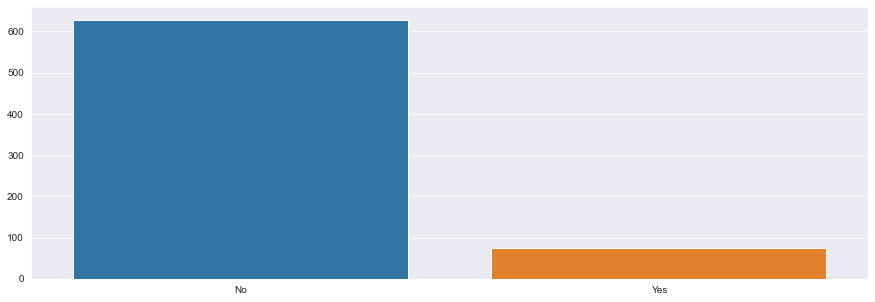

In [7]:
# disability
disability = data_raw.disability.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(15,5))
sns.barplot(x=disability.index, y=disability.values)
plt.show()

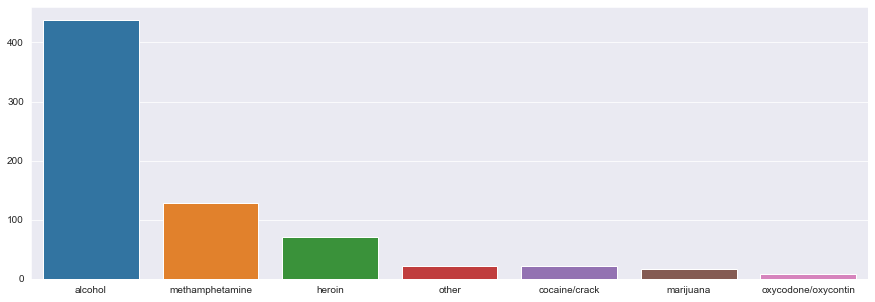

In [8]:
# start_substance
start_substance = data_raw.start_substance.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(15,5))
sns.barplot(x=start_substance.index, y=start_substance.values)
plt.show()

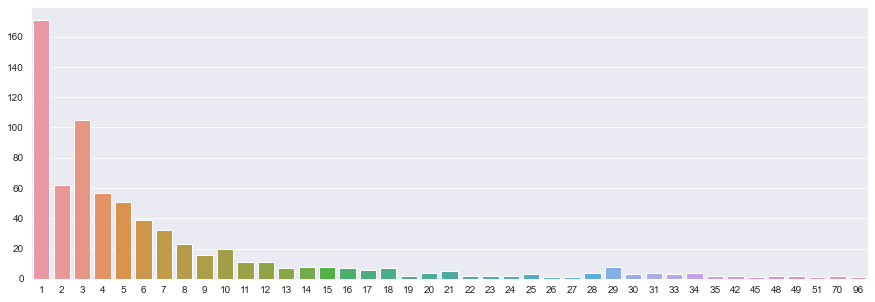

In [9]:
# treatment_days
treatment_days = data_raw.treatment_days.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(15,5))
sns.barplot(x=treatment_days.index, y=treatment_days.values)
plt.show()

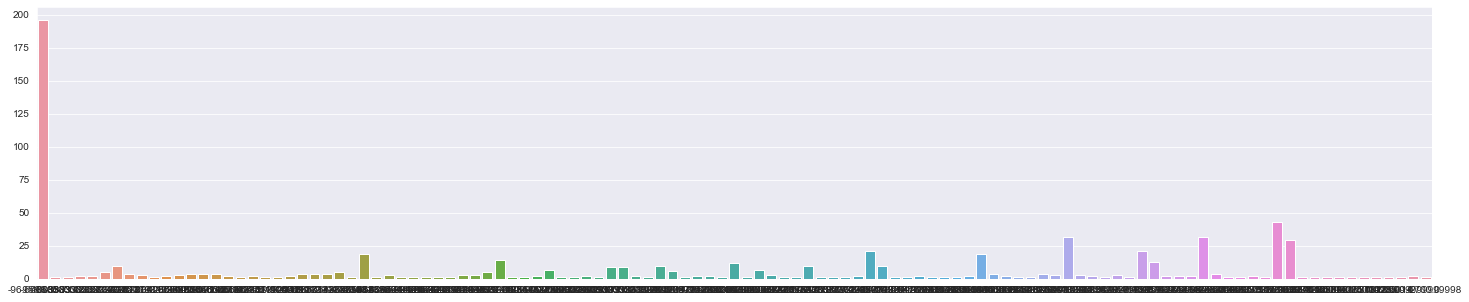

In [10]:
# change_freq_relative
change_freq_relative = data_raw.change_freq_relative.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(25,5))
sns.barplot(x=change_freq_relative.index, y=change_freq_relative.values)
plt.show()

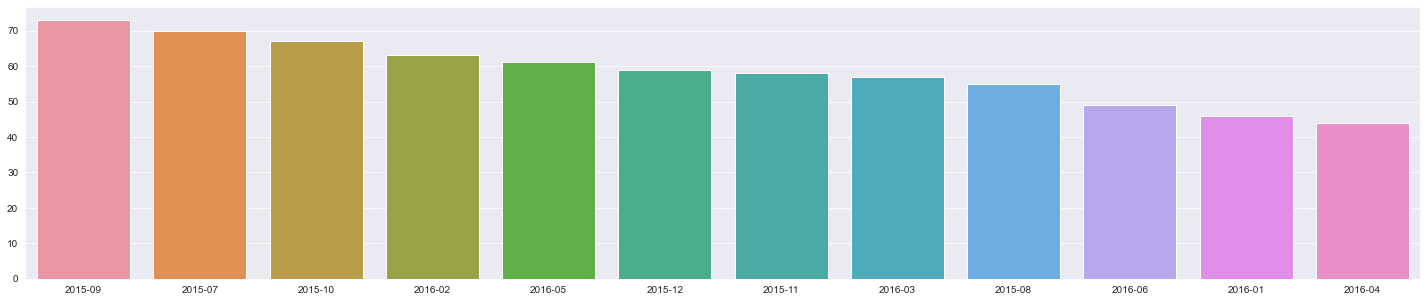

In [11]:
# start_year_month
start_date = data_raw.start_year_month.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(25,5))
sns.barplot(x=start_date.index, y=start_date.values)
plt.show()

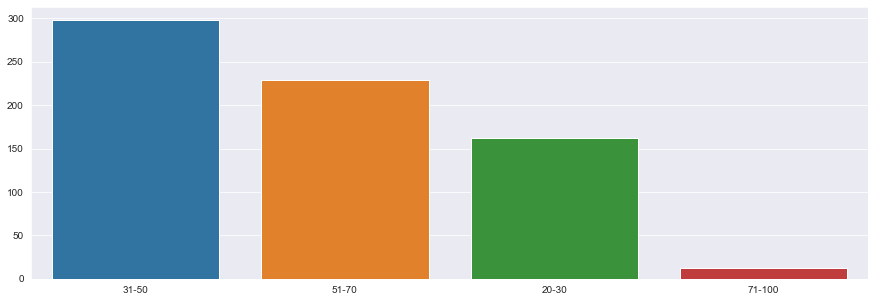

In [12]:
# age_group
age = data_raw.age_group.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(15,5))
sns.barplot(x=age.index, y=age.values)
plt.show()

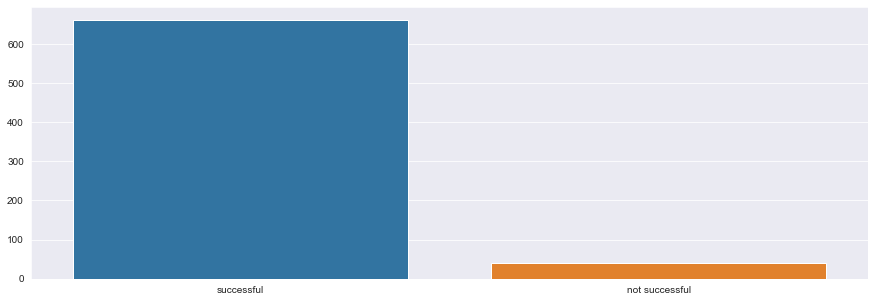

In [13]:
# program_success
program_success = data_raw.program_success.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(15,5))
sns.barplot(x=program_success.index, y=program_success.values)
plt.show()

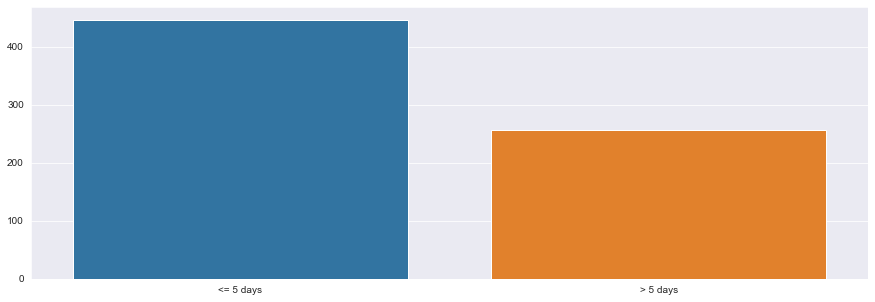

In [14]:
# enrollment_v_target
enrollment_v_target = data_raw.enrollment_v_target.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(15,5))
sns.barplot(x=enrollment_v_target.index, y=enrollment_v_target.values)
plt.show()

#### 1.2 Explore Data By Demographics and Enrollment Lasting <= 5 Days vs > 5 Days

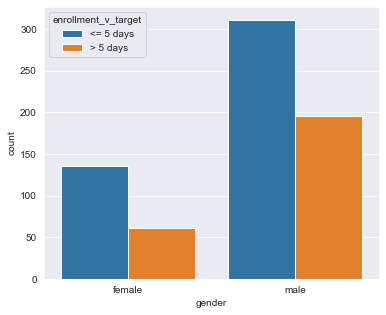

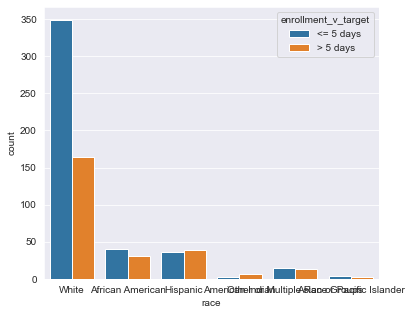

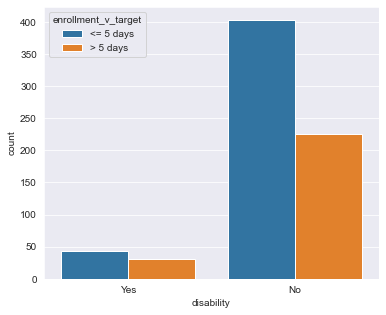

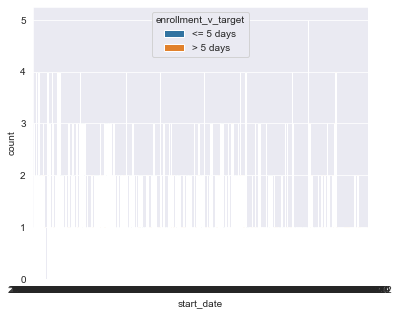

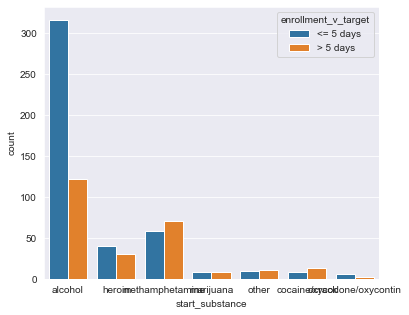

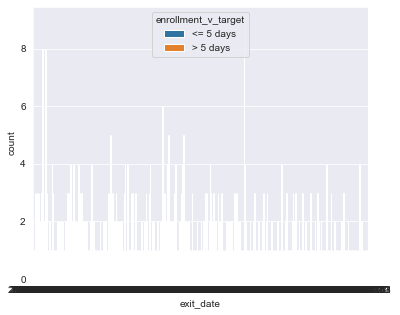

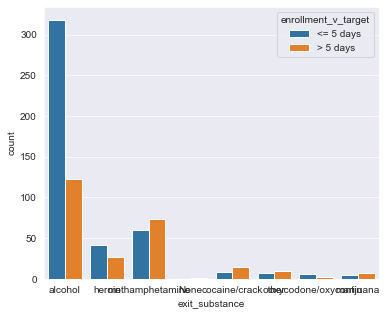

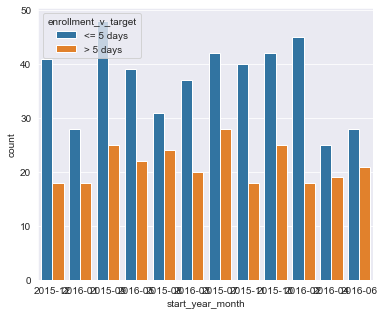

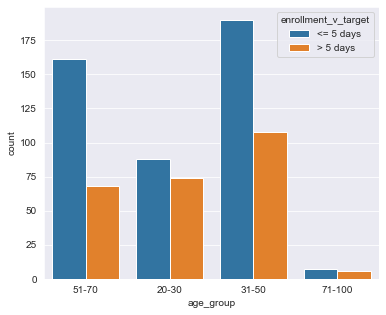

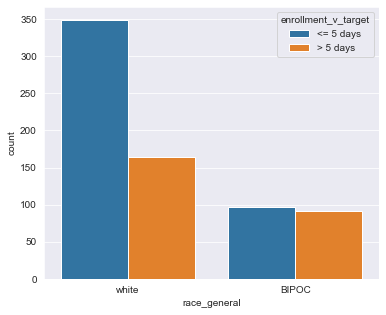

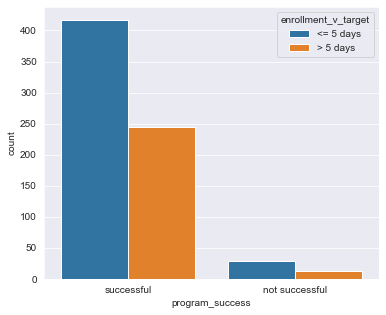

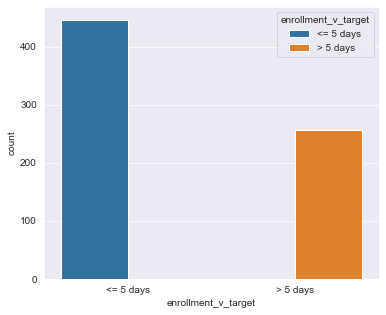

In [15]:
X = list(i for i in data_raw._get_numeric_data().columns)
Y = list(i for i in data_raw.columns if i not in X)

for i in Y:
    plt.figure(figsize=(6,5))
    sns.countplot(x=i, hue='enrollment_v_target', data=data_raw)

#### 1.3 Explore Data By Demographics and Program Success

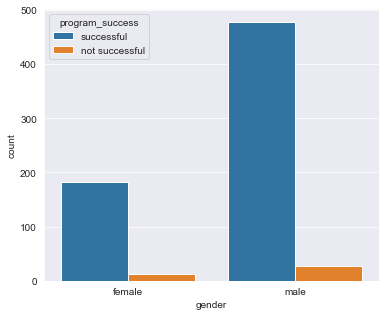

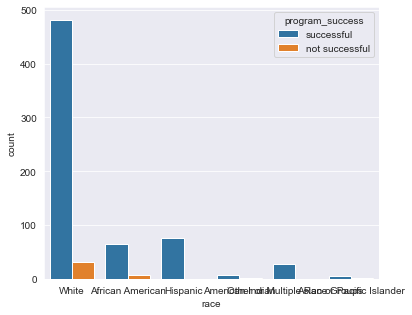

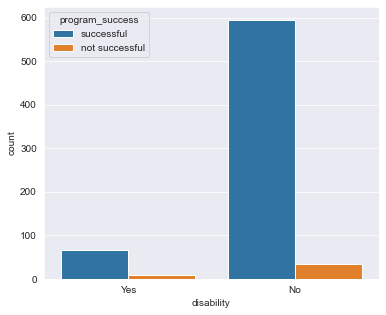

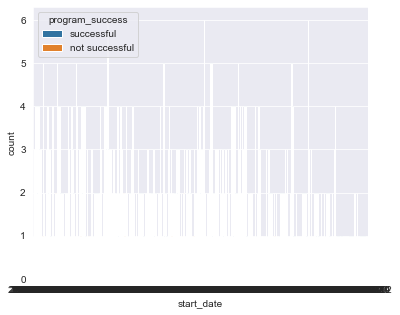

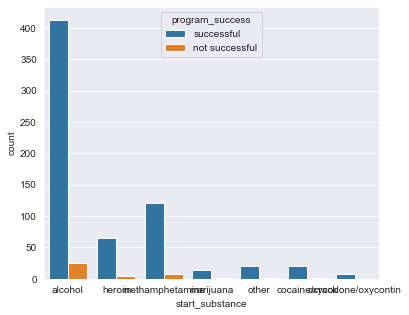

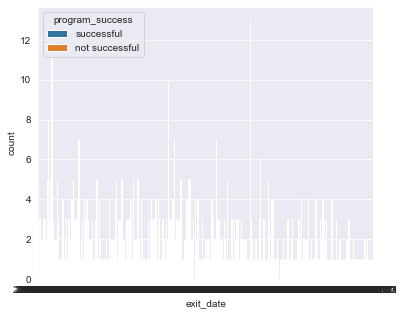

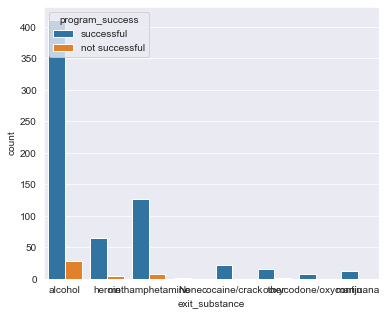

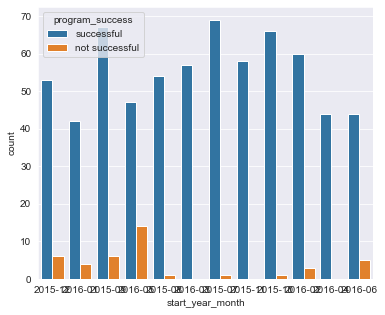

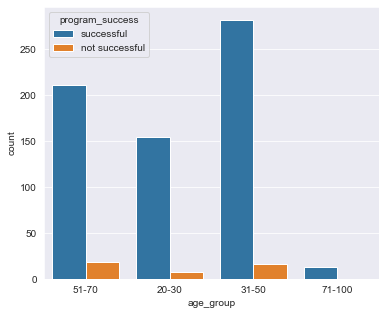

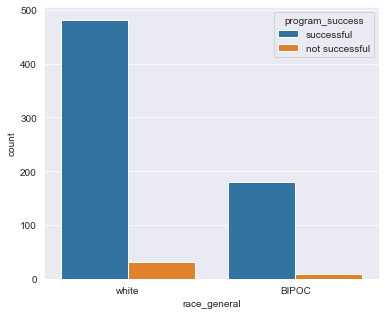

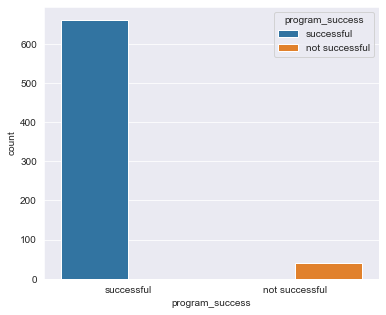

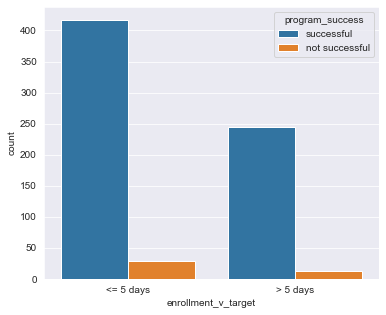

In [17]:
X = list(i for i in data_raw._get_numeric_data().columns)
Y = list(i for i in data_raw.columns if i not in X)

for i in Y:
    plt.figure(figsize=(6,5))
    sns.countplot(x=i, hue='program_success', data=data_raw)

### 2. K Prototypes Clustering

Sources:
* https://zachary-a-zazueta.medium.com/k-prototypes-clustering-for-when-youre-clustering-continuous-and-categorical-data-6ea42c2ab2b9
* https://github.com/zachzazueta/telecom_churn_project/blob/master/Notebook%202%20-%20Cleaning%20and%20KPrototypes2.ipynb

#### 2.1 Running the Model

In [23]:
# preprocessing numerical data in 'data'
Num_features = data.select_dtypes(include=['int64', 'float64']).columns
data[Num_features] = StandardScaler().fit_transform(data[Num_features])
data.head()

gender disability start_substance  treatment_days  change_freq_relative  \
0  female        Yes         alcohol        -0.63549              0.027804   
1  female         No         alcohol        -0.63549              0.246362   
2    male        Yes         alcohol        -0.63549              0.270647   
3    male         No         alcohol        -0.63549             -0.409313   
4    male         No         alcohol        -0.63549             -0.457881   

  start_year_month age_group race_general  
0          2015-12     51-70        white  
1          2016-01     51-70        white  
2          2015-09     51-70        white  
3          2016-05     20-30        BIPOC  
4          2015-08     51-70        white

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 331, ncost: 1833.0025803600042
Run: 1, iteration: 2/100, moves: 31, ncost: 1807.8400502453371
Run: 1, iteration: 3/100, moves: 4, ncost: 1807.2595720278684
Run: 1, iteration: 4/100, moves: 0, ncost: 1807.2595720278684
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 184, ncost: 2140.6842249105284
Run: 2, iteration: 2/100, moves: 348, ncost: 1869.543710739705
Run: 2, iteration: 3/100, moves: 65, ncost: 1807.8424949969974
Run: 2, iteration: 4/100, moves: 4, ncost: 1807.2595720278684
Run: 2, iteration: 5/100, moves: 0, ncost: 1807.2595720278684
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 12, ncost: 1737.213079551108
Run: 3, iteration: 2/100, moves: 1, ncost: 1722.01089868548
Run: 3, iteration: 3/100, moves: 0, ncost: 1722.01089868548
Init: initial

 12%|██████████▌                                                                         | 1/8 [00:09<01:04,  9.16s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 116, ncost: 1715.6395008592583
Run: 1, iteration: 2/100, moves: 23, ncost: 1715.0555138515892
Run: 1, iteration: 3/100, moves: 4, ncost: 1715.017792160387
Run: 1, iteration: 4/100, moves: 0, ncost: 1715.017792160387
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 198, ncost: 1720.5603762328478
Run: 2, iteration: 2/100, moves: 60, ncost: 1714.1245956879022
Run: 2, iteration: 3/100, moves: 16, ncost: 1713.9691657734247
Run: 2, iteration: 4/100, moves: 1, ncost: 1713.9682350279859
Run: 2, iteration: 5/100, moves: 0, ncost: 1713.9682350279859
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 233, ncost: 1716.7153965470009
Run: 3, iteration: 2/100, moves: 56, ncost: 1705.6247969435635
Run: 3, iteration: 3/100, moves: 18, ncost: 1704.8742077091708
Run: 3,

 25%|█████████████████████                                                               | 2/8 [00:24<01:16, 12.71s/it]

Run: 10, iteration: 16/100, moves: 0, ncost: 1680.7210778547947
Best run was number 4
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 291, ncost: 1629.968990750202
Run: 1, iteration: 2/100, moves: 69, ncost: 1618.6563066013766
Run: 1, iteration: 3/100, moves: 22, ncost: 1616.671456205117
Run: 1, iteration: 4/100, moves: 8, ncost: 1616.4110649996821
Run: 1, iteration: 5/100, moves: 1, ncost: 1616.4028307365845
Run: 1, iteration: 6/100, moves: 1, ncost: 1616.397959353188
Run: 1, iteration: 7/100, moves: 0, ncost: 1616.397959353188
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 248, ncost: 1142.4813144224115
Run: 2, iteration: 2/100, moves: 13, ncost: 1139.8512750126592
Run: 2, iteration: 3/100, moves: 4, ncost: 1139.6069440400208
Run: 2, iteration: 4/100, moves: 0, ncost: 1139.6069440400208
Init: initia

 38%|███████████████████████████████▌                                                    | 3/8 [00:38<01:07, 13.47s/it]

Run: 10, iteration: 8/100, moves: 0, ncost: 1656.907214261796
Best run was number 3
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 237, ncost: 1135.780810284962
Run: 1, iteration: 2/100, moves: 45, ncost: 1078.7753253725593
Run: 1, iteration: 3/100, moves: 30, ncost: 1077.7997825314317
Run: 1, iteration: 4/100, moves: 14, ncost: 1077.01408991214
Run: 1, iteration: 5/100, moves: 23, ncost: 1076.487238013682
Run: 1, iteration: 6/100, moves: 1, ncost: 1076.4747049767689
Run: 1, iteration: 7/100, moves: 0, ncost: 1076.4747049767689
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 87, ncost: 1131.3873534761656
Run: 2, iteration: 2/100, moves: 41, ncost: 1128.1292446090645
Run: 2, iteration: 3/100, moves: 60, ncost: 1109.999070935656
Run: 2, iteration: 4/100, moves: 89, ncost: 1088.6364980480282
Run: 2, iteration: 5/100, moves: 93, ncost: 1063.6385116828365
Run: 2

 50%|██████████████████████████████████████████                                          | 4/8 [00:52<00:54, 13.65s/it]

Run: 10, iteration: 4/100, moves: 0, ncost: 1086.9119701115367
Best run was number 8
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 255, ncost: 1356.1971878009174
Run: 1, iteration: 2/100, moves: 110, ncost: 1024.3470767723404
Run: 1, iteration: 3/100, moves: 62, ncost: 1014.4896686665168
Run: 1, iteration: 4/100, moves: 31, ncost: 1012.9895964352919
Run: 1, iteration: 5/100, moves: 33, ncost: 997.5907095842408
Run: 1, iteration: 6/100, moves: 26, ncost: 997.4448324945795
Run: 1, iteration: 7/100, moves: 4, ncost: 997.4336467791494
Run: 1, iteration: 8/100, moves: 0, ncost: 997.4336467791494
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 267, ncost: 989.7088428727449
Run: 2, iteration: 2/100, moves: 62, ncost: 986.2321664681974
Run: 2, iteration: 3/100, moves: 10, ncost: 985.8928305446427
Run: 2, ite

 62%|████████████████████████████████████████████████████▌                               | 5/8 [01:14<00:49, 16.57s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 239, ncost: 1007.5944895053696
Run: 1, iteration: 2/100, moves: 111, ncost: 998.9490668636834
Run: 1, iteration: 3/100, moves: 19, ncost: 998.0892733141771
Run: 1, iteration: 4/100, moves: 12, ncost: 996.5341863157823
Run: 1, iteration: 5/100, moves: 6, ncost: 996.2820159887822
Run: 1, iteration: 6/100, moves: 12, ncost: 995.9994167766204
Run: 1, iteration: 7/100, moves: 8, ncost: 995.7124275896178
Run: 1, iteration: 8/100, moves: 1, ncost: 995.7042690119505
Run: 1, iteration: 9/100, moves: 0, ncost: 995.7042690119505
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing ce

 75%|███████████████████████████████████████████████████████████████                     | 6/8 [01:35<00:36, 18.16s/it]

Run: 10, iteration: 7/100, moves: 0, ncost: 1003.073194610944
Best run was number 9
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 376, ncost: 1115.468765238948
Run: 1, iteration: 2/100, moves: 80, ncost: 916.0000955311571
Run: 1, iteration: 3/100, moves: 22, ncost: 908.0640252066513
Run: 1, iteration: 4/100, moves: 4, ncost: 908.0163416439116
Run: 1, iteration: 5/100, moves: 1, ncost: 908.0159020976097
Run: 1, iteration: 6/100, moves: 0, ncost: 908.0159020976097
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 372, ncost: 959.0433569830637
Run: 2, iteration: 2/100, moves: 99, n

 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [01:58<00:19, 19.56s/it]

Run: 10, iteration: 7/100, moves: 0, ncost: 948.5704001461908
Best run was number 4
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 306, ncost: 932.6493730268483
Run: 1, iteration: 2/100, moves: 57, ncost: 904.2585549851007
Run: 1, iteration: 3/100, moves: 34, ncost: 897.697360472489
Run: 1, iteration: 4/100, moves: 25, ncost: 894.8579121837563
Run: 1, iteration: 5/100, moves: 19, ncost: 893.7984213574531
Run: 1, iteration: 6/100, moves: 12, ncost: 890.7347559178432
Run: 1, iteration: 7/100, moves: 9, ncost: 887.3537820272015
Run: 1, iteration: 8/100, moves: 0, ncost: 887.3537820272015
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 342, ncost: 873.5810740849081
Run: 2, iteration: 2/100, moves: 98, ncost: 862.5655026142514
Run: 2, iteration: 3/100, moves: 34, ncost: 861.9924954644539
Run: 2, iteration: 4/100, moves: 11, ncost: 861.7702950425276
Run: 2, itera

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:24<00:00, 18.10s/it]

Run: 10, iteration: 14/100, moves: 0, ncost: 893.0470712012828
Best run was number 4


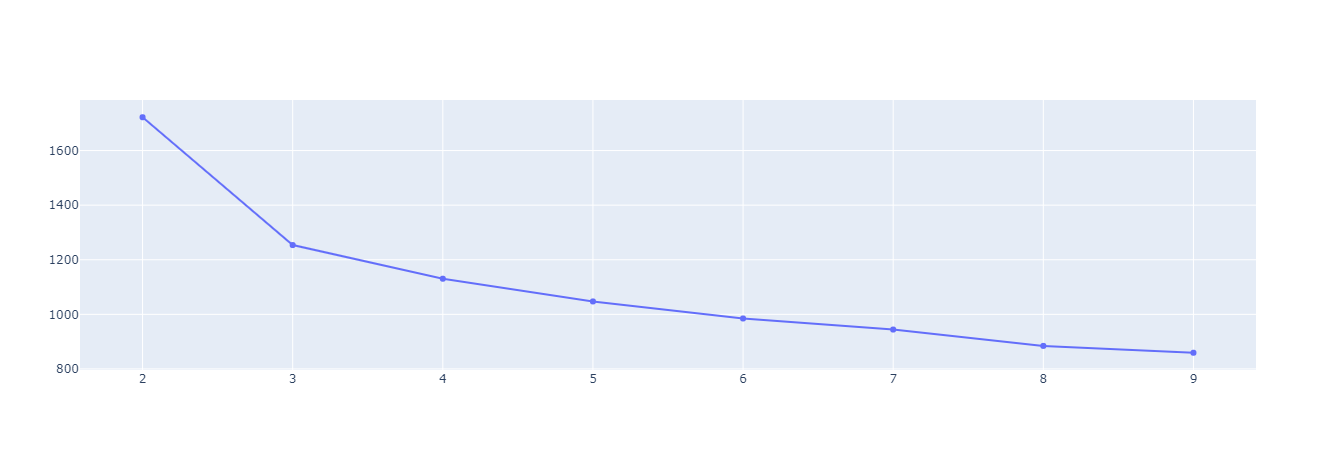

In [24]:
# id number of appropriate clusters with Huang initialization method 
    ## (i.e., with Huang model selects the first k distinct objects from the dataset
    ## as the initial k-modes and then assign the most frequent categories equally to
    ## the initial k-modes)
costs = []
n_clusters = []
cat_cols = [0, 1, 2, 5, 6, 7]
for i in tqdm(range(2, 10)):
    try:
        kproto = KPrototypes(n_clusters=i, init='Huang', verbose=2)
        clusters = kproto.fit_predict(data, categorical=cat_cols)
        costs.append(kproto.cost_)
        n_clusters.append(i)
        #clusters_assigned.append(clusters)
    except:
        print(f"Can't cluster with {i} clusters")
fig = go.Figure(data=go.Scatter(x=n_clusters, y=costs))
fig.show()

In [25]:
# plot cluster centroids from trained model and print training statistics
style.use("ggplot")
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

kproto = KPrototypes(n_clusters=4, init='Huang', verbose=2)
clusters = kproto.fit_predict(data, categorical=cat_cols)

# print cluster centroids of the trained model.
print(kproto.cluster_centroids_)

# print training statistics
print(kproto.cost_)
print(kproto.n_iter_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 93, ncost: 1181.1475375527243
Run: 1, iteration: 2/100, moves: 10, ncost: 1180.1642395362687
Run: 1, iteration: 3/100, moves: 6, ncost: 1179.7380308256008
Run: 1, iteration: 4/100, moves: 1, ncost: 1179.7377420254033
Run: 1, iteration: 5/100, moves: 0, ncost: 1179.7377420254033
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 282, ncost: 1133.612072760903
Run: 2, iteration: 2/100, moves: 96, ncost: 1131.5753690874096
Run: 2, iteration: 3/100, moves: 28, ncost: 1131.124674151689
Run: 2, iteration: 4/100, moves: 1, ncost: 1131.1167742796429
Run: 2, iteration: 5/100, moves: 0, ncost: 1131.1167742796429
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 398, ncost: 1655.0003520713813
Run: 3, iteration: 2/100, moves: 101, ncost: 1616.9305360735475
Run: 3, 

In [26]:
# print count of each cluster
print(pd.Series(clusters).value_counts())

0    330
1    306
3     63
2      3
dtype: int64


In [27]:
# setting the objects to category 
cat_data = data.copy()
for i in cat_data.select_dtypes(include='object'):
    cat_data[i] = cat_data[i].astype('category')

In [28]:
# get cluster labels per enrollment program instance (i.e., patient)
proto_labs = kproto.labels_

In [29]:
# check that CV F1 score is close to 1 to ensure appropriate amount of clusters chosen
clf_kp = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_kp = cross_val_score(clf_kp, cat_data, proto_labs, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

The least populated class in y has only 3 members, which is less than n_splits=5.


[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for K-Prototypes clusters is 0.8259712987884154


In [30]:
# fit 'clf_kp'
clf_kp.fit(cat_data, proto_labs)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree


LGBMClassifier(colsample_by_tree=0.8)

In [31]:
# further prep model results for visualizing outcome
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(cat_data)

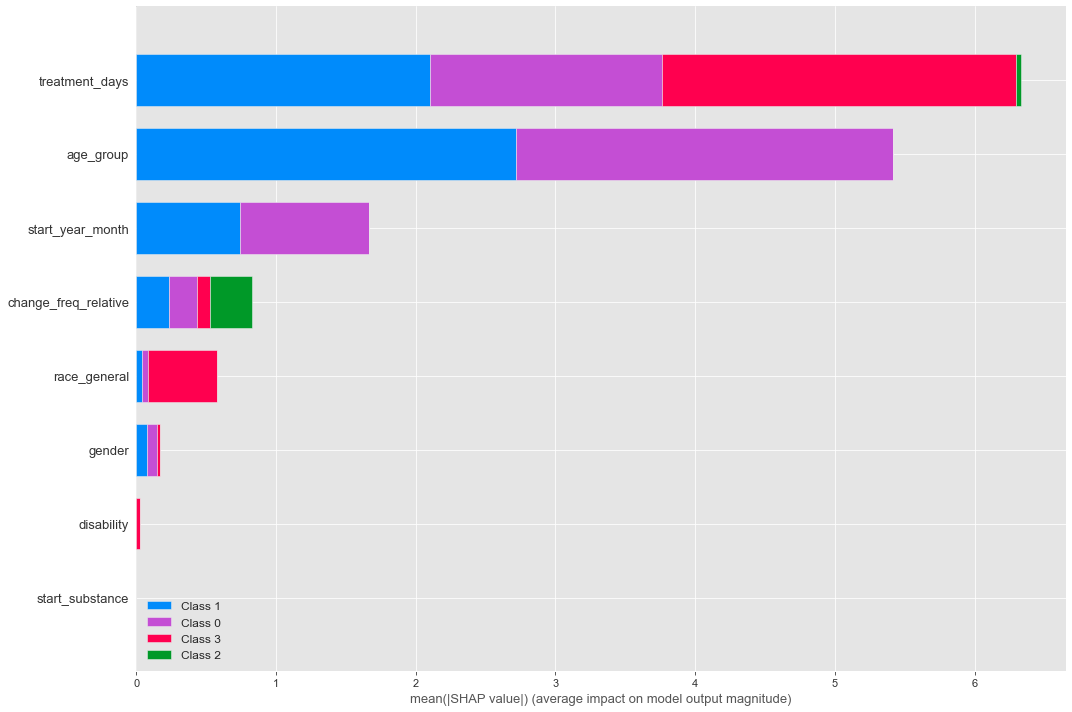

In [32]:
# plot model outcome
shap.summary_plot(shap_values_kp, cat_data, plot_type="bar", plot_size=(15, 10))

#### 2.2 Post Modeling Data Manipulations

In [35]:
# add categorized cluster id to each program enrollment instance (i.e., patient) with a new column, 'cluster' for both 'data' and 'data2'
#proto_labs = kproto.labels_
data_raw['cluster'] = proto_labs
data['cluster'] = proto_labs
#data['age'] = data_raw['age']

In [200]:
# create new 'data_raw' columns, that both sum and take the mean of important columns of interest to create counts and averages per demographic category of interest
data_raw['BIPOC'] = data_raw['race_general'].apply(lambda x: 1 if x=='BIPOC' else 0)
data_raw['white'] = data_raw['race_general'].apply(lambda x: 1 if x=='white' else 0)
data_raw['male'] = data_raw['gender'].apply(lambda x: 1 if x=='male' else 0)
data_raw['female'] = data_raw['gender'].apply(lambda x: 1 if x=='female' else 0)
data_raw['disabled'] = data_raw['disability'].apply(lambda x: 1 if x=='Yes' else 0)
data_raw['not_disabled'] = data_raw['disability'].apply(lambda x: 1 if x=='No' else 0)
data_raw['alcohol'] = data_raw['start_substance'].apply(lambda x: 1 if x=='alcohol' else 0)
data_raw['heroin'] = data_raw['start_substance'].apply(lambda x: 1 if x=='heroin' else 0)
data_raw['methamphetamine'] = data_raw['start_substance'].apply(lambda x: 1 if x=='methamphetamine' else 0)
data_raw['marijuana'] = data_raw['start_substance'].apply(lambda x: 1 if x=='marijuana' else 0)
data_raw['cocaine_crack'] = data_raw['start_substance'].apply(lambda x: 1 if x=='cocaine/crack' else 0)
data_raw['oxycodone_oxycontin'] = data_raw['start_substance'].apply(lambda x: 1 if x=='oxycodone/oxycontin' else 0)
data_raw['successful'] = data_raw['program_success'].apply(lambda x: 1 if x=='successful' else 0)
data_raw['not_successful'] = data_raw['program_success'].apply(lambda x: 1 if x=='not successful' else 0)
data_raw['<= 5 days'] = data_raw['enrollment_v_target'].apply(lambda x: 1 if x=='<= 5 days' else 0)
data_raw['> 5 days'] = data_raw['enrollment_v_target'].apply(lambda x: 1 if x=='> 5 days' else 0)
data_raw['aged 20-30'] = data_raw['age_group'].apply(lambda x: 1 if x=='20-30' else 0)
data_raw['aged 31-50'] = data_raw['age_group'].apply(lambda x: 1 if x=='31-50' else 0)
data_raw['aged 51-70'] = data_raw['age_group'].apply(lambda x: 1 if x=='51-70' else 0)
data_raw['aged 71-100'] = data_raw['age_group'].apply(lambda x: 1 if x=='71-100' else 0)
data_raw['july_2015'] = data_raw['start_year_month'].apply(lambda x: 1 if x=='2015-07' else 0)
data_raw['aug_2015'] = data_raw['start_year_month'].apply(lambda x: 1 if x=='2015-08' else 0)
data_raw['sept_2015'] = data_raw['start_year_month'].apply(lambda x: 1 if x=='2015-09' else 0)
data_raw['oct_2015'] = data_raw['start_year_month'].apply(lambda x: 1 if x=='2015-10' else 0)
data_raw['nov_2015'] = data_raw['start_year_month'].apply(lambda x: 1 if x=='2015-11' else 0)
data_raw['dec_2015'] = data_raw['start_year_month'].apply(lambda x: 1 if x=='2015-12' else 0)
data_raw['jan_2016'] = data_raw['start_year_month'].apply(lambda x: 1 if x=='2016-01' else 0)
data_raw['feb_2016'] = data_raw['start_year_month'].apply(lambda x: 1 if x=='2016-02' else 0)
data_raw['march_2016'] = data_raw['start_year_month'].apply(lambda x: 1 if x=='2016-03' else 0)
data_raw['april_2016'] = data_raw['start_year_month'].apply(lambda x: 1 if x=='2016-04' else 0)
data_raw['may_2016'] = data_raw['start_year_month'].apply(lambda x: 1 if x=='2016-05' else 0)
data_raw['june_2016'] = data_raw['start_year_month'].apply(lambda x: 1 if x=='2016-06' else 0)

In [201]:
# find demographic attributes per cluster
k_composition = data_raw.groupby('cluster').agg({'male':'sum',
                                            'female': 'sum',
                                            'BIPOC':'sum', 
                                            'white':'sum',
                                            'disabled': 'sum',
                                            'not_disabled': 'sum',
                                            'alcohol' : 'sum',
                                            'heroin' : 'sum', 
                                            'methamphetamine' : 'sum', 
                                            'marijuana' : 'sum', 
                                            'cocaine_crack' : 'sum',
                                            'oxycodone_oxycontin' : 'sum',
                                            'treatment_days' : 'median', 
                                            'start_freq' : 'median',
                                            'change_freq_relative' : 'median',
                                            'july_2015' : 'sum', 
                                            'aug_2015' : 'sum',
                                            'sept_2015' : 'sum',
                                            'oct_2015' : 'sum',
                                            'nov_2015' : 'sum',
                                            'dec_2015' : 'sum',
                                            'jan_2016' : 'sum',
                                            'feb_2016' : 'sum',
                                            'march_2016' : 'sum',
                                            'april_2016' : 'sum',
                                            'may_2016' : 'sum',
                                            'june_2016' : 'sum',
                                            'aged 20-30' : 'sum',
                                            'aged 31-50' : 'sum',
                                            'aged 51-70' : 'sum',
                                            'aged 71-100' : 'sum',
                                            'successful' : 'sum',
                                            'not_successful' : 'sum',
                                            '<= 5 days' : 'sum',
                                            '> 5 days' : 'sum'
                                              }).reset_index()[['cluster', 'male', 'female', 'BIPOC', 'white', 'disabled', 
                                                                'not_disabled', 'alcohol', 'heroin', 'methamphetamine', 'marijuana',
                                                                'cocaine_crack', 'oxycodone_oxycontin', 'treatment_days', 'start_freq', 
                                                                'change_freq_relative', 'july_2015', 'aug_2015', 'sept_2015', 'oct_2015',
                                                                'nov_2015', 'dec_2015', 'jan_2016', 'feb_2016', 'march_2016', 'april_2016',
                                                                'may_2016', 'june_2016', 'aged 20-30', 'aged 31-50', 'aged 51-70', 
                                                                'aged 71-100', 'successful', 'not_successful', '<= 5 days', '> 5 days']]

k_composition

cluster  male  female  BIPOC  white  disabled  not_disabled  alcohol  \
0        0   239      91     79    251        28           302      201   
1        1   219      87     66    240        29           277      207   
2        2     3       0      1      2         1             2        1   
3        3    45      18     43     20        16            47       29   

   heroin  methamphetamine  ...  may_2016  june_2016  aged 20-30  aged 31-50  \
0      29               62  ...        28         24          61         248   
1      30               46  ...        28         17          76          20   
2       1                0  ...         0          1           1           2   
3      10               20  ...         5          7          24          28   

   aged 51-70  aged 71-100  successful  not_successful  <= 5 days  > 5 days  
0          12            9         316              14        188       142  
1         206            4         287              19        256        50  
2           0            0           0               3          2         1  
3          11            0          58               5          0        63  

[4 rows x 36 columns]

#### 2.5 Export Modeled Data

In [203]:
# write 'k_composition' to a csv
k_composition.to_csv('data/processed/k_composition.csv', encoding = 'utf-8', index = False)

# write 'data_raw' to a csv
data_raw.to_csv('data/processed/data_raw.csv', encoding = 'utf-8', index = False)

### 3 Exploring Model Outcomes VISUALLY

#### 3.1 Exploring Treatment Days

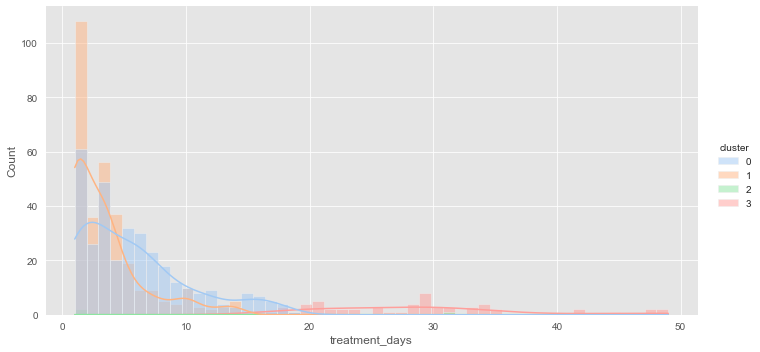

In [204]:
sns.displot(data_raw[data_raw['treatment_days']<=50], x='treatment_days', hue='cluster', kde=True, palette = "pastel", height=5, aspect=2, bins=50)
# cluster 0: between 1 and 20, skewed towards 1 (left skew)
# cluster 1: between 1 and 15-ish, more skewed towards 1 (left skew)
# cluster 2: OUTLIER, no patter
# cluster 3: between 15ish and 35 ish, bell shaped in middle (25ish)

Dataset has 0 variance; skipping density estimate.


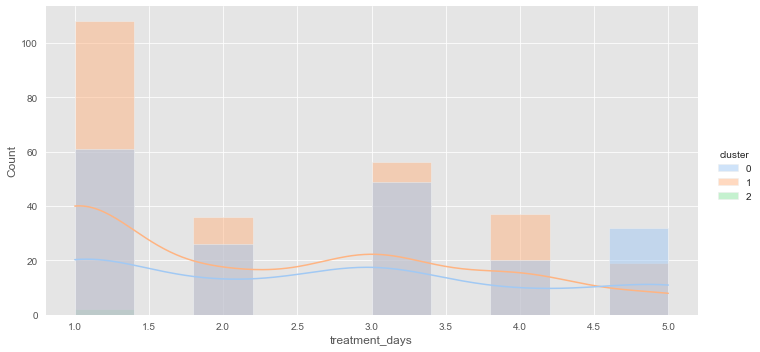

In [205]:
# zoom in on treatment days <=5
sns.displot(data_raw[data_raw['treatment_days']<=5], x='treatment_days', hue='cluster', kde=True, palette = "pastel", height=5, aspect=2)
# cluster 0: mean for less than 5 days is around 3 days
# cluster 1: mean for less than 5 days is skewed right a bit, more people in for just 1 day compared to clsuter 0
# cluster 2: OUTLIER, no pattern but some staying less than 5
# cluster 3: nobody is staying less than 5 days in this group (treatment usually lasts 20-40 ish days for this group)

Dataset has 0 variance; skipping density estimate.


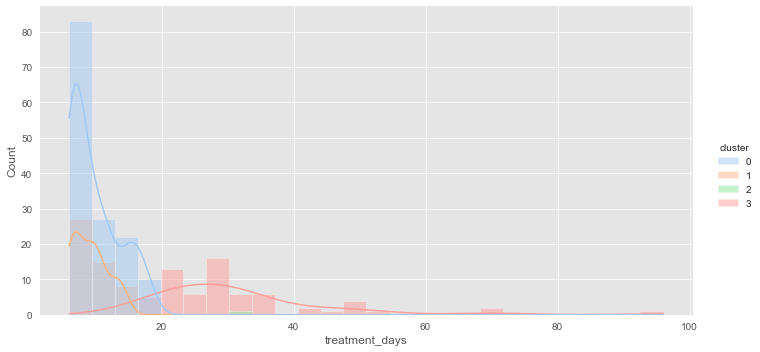

In [206]:
# zoom in on treatment days > 5
sns.displot(data_raw[data_raw['treatment_days']>5], x='treatment_days', hue='cluster', kde=True, palette = "pastel", height=5, aspect=2)
# cluster 0: for more than 5 days, skewed left,   but less than cluster 1
# cluster 1: for more than 5 days, skewed let (more than cluster 0)
# cluster 2: OUTLIER, no pattern but some staying more than 5 days (around 30ish days)
# cluster 3: everybody is staying more than 5 days in this group (treatment usually lasts 20-40 ish days for this group)

Dataset has 0 variance; skipping density estimate.


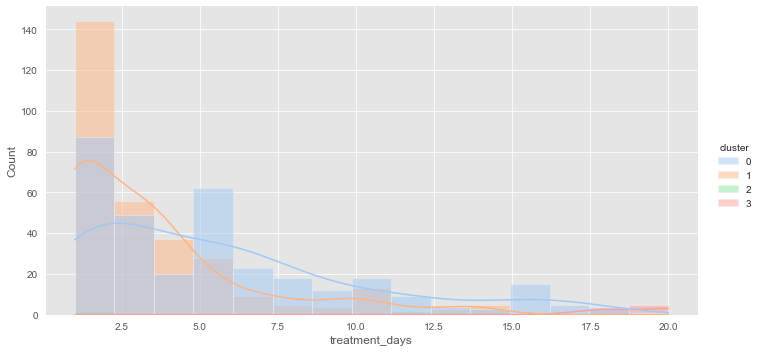

In [207]:
sns.displot(data_raw[data_raw['treatment_days']<=20], x='treatment_days', hue='cluster', kde=True, palette = "pastel", height=5, aspect=2)
# people who stay mostly after 5 days come from predominantly:
    # cluster 3: ALL more than 5 days
    # cluster 0: some after 5 days (less than cluster 3 but more than cluster 1)
    # cluster 1: some after 5 days (but much less than cluster 3 and less than cluster 0)
    # cluster 2: OUTLIER, no patter! (but some are more than 5 days)

#### 3.2 Exploring Age Group

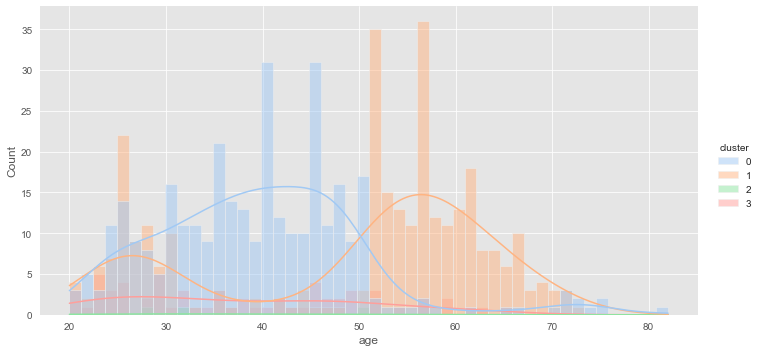

In [208]:
sns.displot(data_raw, x='age', hue='cluster', kde=True, palette = "pastel", height=5, aspect=2, bins=50)
# cluster 0 : mostly people between 20 and 50, bell around 40 but sligthly skewed right
# cluster 1: mostly people between 50 and 70 but also some people between 20 and 30 - almost bimodal, but skew right
# cluser 2: OUTLIER, no pattern
# cluster 3: people between 20 and 60, pretty evenly distributed bet skewed towards 20s (left)

#### 3.3 Exploring Start Year and Month of Treatment

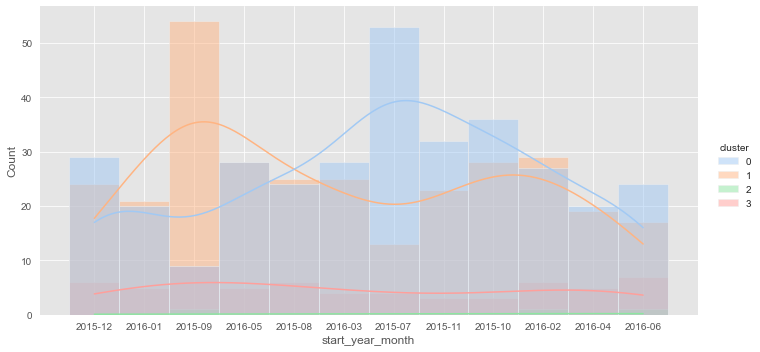

In [209]:
sns.displot(data_raw, x='start_year_month', hue='cluster', kde=True, palette = "pastel", height=5, aspect=2)
# cluster 0 :
# cluster 1:
# cluster 2:
# cluster 3: 

# need to order x in order to plot
# order=['2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06'])

#### 3.4 Exploring Change in Relative Frequency of Substance Use

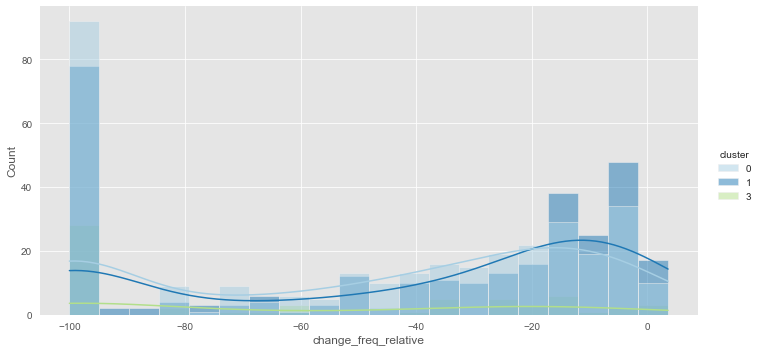

In [210]:
sns.displot(data_raw[data_raw['change_freq_relative']<=10], x='change_freq_relative', hue='cluster', kde=True, palette = "Paired", height=5, aspect=2, bins=20)
# cluster 0: bimodal, many people reduce substance use by roughly 20%, other people by 100%
# cluster 1: bimodal, many people reduce substance use by roughly 15%, other people by 100% (less people getting 100% clean
    ## than cluster 0, and less people reducing their use by slightly compared to cluster 0 (i.e., by about 10-15% instead of 20%))
# cluster 2: OUTLIER
# cluster 3: uniform across - really random as to the reduction in use

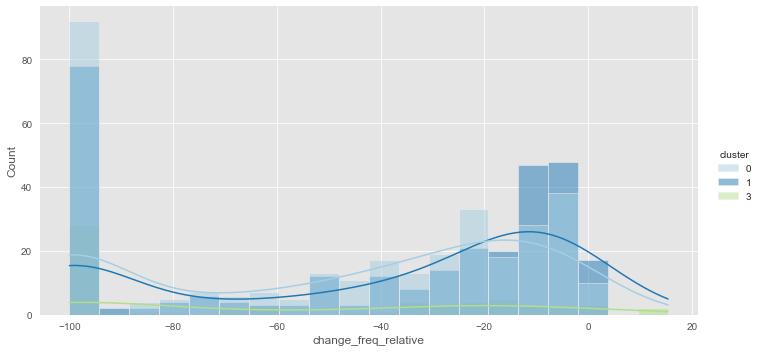

In [211]:
sns.displot(data_raw[data_raw['change_freq_relative']<=20], x='change_freq_relative', hue='cluster', kde=True, palette = "Paired", height=5, aspect=2, bins=20)
# cluster 0: bimodal, many people reduce substance use by roughly 20%, other people by 100%
# cluster 1: bimodal, many people reduce substance use by roughly 15%, other people by 100% (less people getting 100% clean
    ## than cluster 0, and less people reducing their use by slightly compared to cluster 0 (i.e., by about 10-15% instead of 20%))
# cluster 2: OUTLIER
# cluster 3: uniform across - really random as to the reduction in use

#### 3.5 Exploring Race

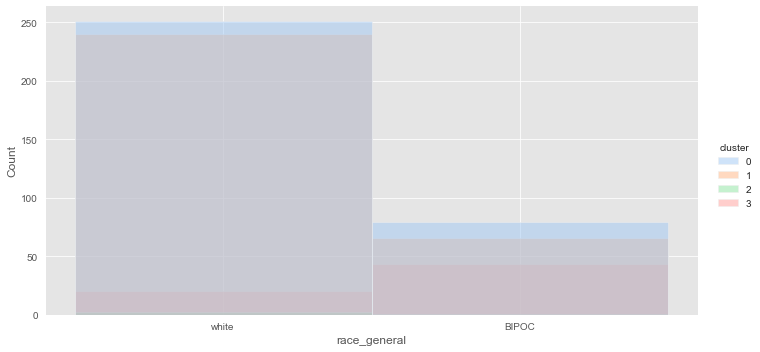

In [212]:
sns.displot(data_raw, x='race_general', hue='cluster', kde=False, palette = "pastel", height=5, aspect=2, bins=50)
# cluster 0 : mostly white people 
# cluster 1: mostly white people (with proportion of BIPOC people about the same as cluster 1)
# cluster 2: OUTLIER, no pattern
# cluster 3: Mostly BIPOC people

#### 3.6 Exploring Gender

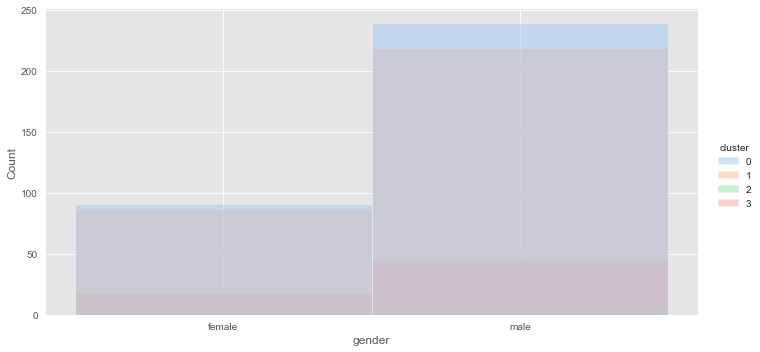

In [213]:
sns.displot(data_raw, x='gender', hue='cluster', kde=False, palette = "pastel", height=5, aspect=2, bins=50)
# cluster 0 : mostly male
# cluster 1: mostly male
# cluster 2: OUTLIER, no pattern
# cluster 3: mostly male, but bigger proportion of female

#### 3.7 Exploring Disability

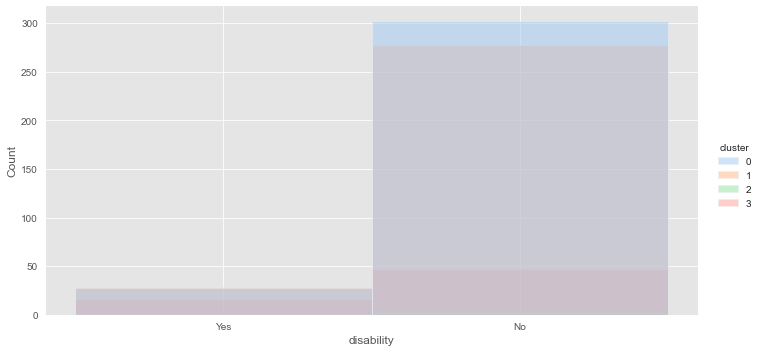

In [214]:
sns.displot(data_raw, x='disability', hue='cluster', kde=False, palette = "pastel", height=5, aspect=2, bins=50)
# cluster 0 : mostly not disabled
# cluster 1: mostly not disabled
# cluster 2: OUTLIER, no pattern
# cluster 3: mostly not disabled, but higher proportion of disabled 

#### 3.8 Exploring Start Substance of Primary Use

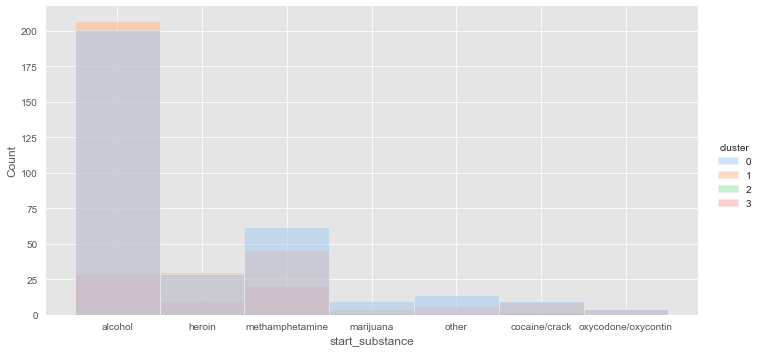

In [215]:
sns.displot(data_raw, x='start_substance', hue='cluster', kde=False, palette = "pastel", height=5, aspect=2, bins=50)
# cluster 0 : mostly alcohol and some methamphetamine (higher proporiton of meth than cluster 1) and less but still some heroin (very little marijuana, other, cocaine/crack/oxycodone/oxycontin)
# cluster 1: mostly alcohol, also methamphetamine and heroin (but smaller proprotion of meth than cluster 1) and less but still some  heroin (very little marijuana, other, cocaine/crack/oxycodone/oxycontin)
# cluster 2: OUTLIER, no pattern
# cluster 3: mostly alcohol and methamphetamine (almost equal, but alcohol slightly more) with some heroin (very little marijuana, other, cocaine/crack/oxycodone/oxycontin)

#### 3.9 Summarizing What We Know VISUALLY

##### Cluster 0:
* This cluster is composed of predominantly white males without disabilities between the ages of 20 and 50 years old (i.e., middle-aged) that predominantly use alcohol.  These people also use methamphetamine and heroin (to a lesser  extent).  These people are usually in treatment for about 1-20 days, which is longer than Cluster 1 people (about 1-15 days) and less than Cluster 3 people (about 20-40 days).  These people also tend to be THE MOST SUCCESSFUL at decreasing their substance use after treatment (i.e., they benefit the most from treatment).  When compared to Cluster 1, people in this group make up less of the people who are in treatment for less than or equal to 5 days (i.e., the amount of time expected in treatment).  While some people in this cluster spend more than 5 days in treatment, they represent less people who spend more than 5 days in treatment when compared to Cluster 3.

##### Cluster 1:
* This cluster is composed of predominantly white males without disabilities that are both older (i.e., 50-70ish) and younger (i.e., 20-30ish) that predominantly use alcohol.  These people also use methamphetamine and heroin (to a lesser extent).  These people are usually in treatment for about 1-15 days, which is shorter than both Cluster 0 people (about 1-20 days) and Cluster 3 people (about 20-40 days).  The people in this cluster are more successful than Cluster 3 people at decreasing their substance use after treatment, however, they decrease their substance use after treatment slightly less than Cluster 0 people (i.e., they benefit more from treatment than Cluster 3 people, but they also benefit slightly less from treatment when compared to Cluster 0 people).  When compared to Cluster 0, people in this group make up more of the people who are in treatment for less than or equal to 5 days (i.e., the amount of time expected in treatment).  People in this cluster represent less people who spend more than 5 days in treatment when compared to the other clusters.

##### Cluster 2:
* This cluster represent outliers.  In the exploratory analysis phase of this project, it was determined that some people changed substances during treatment (e.g., they went from primarily using methamphetamine to primarily using alcohol), some people increased their frequency of substance use after treatment (i.e., they got worse after treatment), and some people even changed substances during treatment AND increased their frequency after treatment.  It is important to approach these cases with a more nuanced lense, and it is suggested that this is done with qualitative tools.  A case-by-case basis be used to approach these outlier patients, and a series of interviewing could take place in order to better understand how their experiences during treatment could have contributed to such changes in substance use and/or increase in substance use frequency.

##### Cluster 3:
* This cluster is composed of predominantly BIPOC people of all ages, a higher proportion of whom are female (when compared to other clusters) and a higher proportion of whome have disabilities (when compared to other clusters).  These people primarily use alcohol and methamphetamine (to a lesser extent).  People in this cluster are also usually in treatment for much longer than the other clusters (around 20-40 days), and the decrease in substance use after treatment is far less consistent for people in this cluster when compared to people in Cluster 0 and Cluster 2 (i.e., people in Cluster 3 do not benefit from treatment as well as people do in Cluster 0 and Cluster 1).


**** NOTES: 
* The main difference in characteristics between Cluster 0 and Cluster 1 is that Cluster 0 is mostly middle-aged white, male, non-disabled people who stay in treatment slightly longer and who are slightly more successful in reducing their substance use than Cluster 1 people who are mostly younger and older white, male, non-disabled people who stay in treatment for slightly less time (compared to Cluster 0).  Both Cluster 0 and Cluster 1 also use the same primary substances with similar popularity.

    * Thus, given this information, it could be interpreted that:
        * middle-aged people seem to benefit the most from treatment (seeing as Cluster 0 benefits the best from treatment and has less younger and older people compared to Cluster 1 and Cluster 3)
    * White, males who are not disabled benefit the most from treatment
    * BIPOC females who are disabled benefit the least from treatment

    * Slightly more time in treatment than the target 5 days could result in better outcomes for substance use reduction.  Using time in treatment as a metric alone may not a sufficient means to understand 'success' of patient outcomes.  It may be better to reconsider expectations for what the most appropriate 'target number of days' in treatment.

STILL MUST CONSIDER START MONTH/DATE in OBSERVABLE!!! Staffing could have an impact on success, as could seasonal economy and trends in society

### 4 Exploring Model Outcomes Numerically

In [216]:
# read in processed 'k_composition' data
k_explore = pd.read_csv("data/processed/k_composition.csv")

#### 4.1 Prepare Demographic Proportions per Cluster

In [217]:
# calculate demographic proportions per cluster
k_explore['male_proportion'] = (k_explore['male'] / (k_explore['male'] + k_explore['female'])) * 100
k_explore['female_proportion'] = (k_explore['female'] / (k_explore['male'] + k_explore['female'])) * 100

k_explore['BIPOC_proportion'] = (k_explore['BIPOC'] / (k_explore['BIPOC'] + k_explore['white'])) * 100
k_explore['white_proportion'] = (k_explore['white'] / (k_explore['BIPOC'] + k_explore['white'])) * 100

k_explore['disabled_proportion'] = (k_explore['disabled'] / (k_explore['disabled'] + k_explore['not_disabled'])) * 100
k_explore['not_disabled_proportion'] = (k_explore['not_disabled'] / (k_explore['disabled'] + k_explore['not_disabled'])) * 100

k_explore['alcohol_proportion'] = (k_explore['alcohol'] / (k_explore['alcohol'] + k_explore['heroin'] + k_explore['methamphetamine'] + 
                                                          k_explore['marijuana'] + k_explore['cocaine_crack'] + k_explore['oxycodone_oxycontin'])) * 100
k_explore['heroin_proportion'] = (k_explore['heroin'] / (k_explore['alcohol'] + k_explore['heroin'] + k_explore['methamphetamine'] + 
                                                          k_explore['marijuana'] + k_explore['cocaine_crack'] + k_explore['oxycodone_oxycontin'])) * 100
k_explore['methamphetamine_proportion'] = (k_explore['methamphetamine'] / (k_explore['alcohol'] + k_explore['heroin'] + k_explore['methamphetamine'] + 
                                                          k_explore['marijuana'] + k_explore['cocaine_crack'] + k_explore['oxycodone_oxycontin'])) * 100
k_explore['marijuana_proportion'] = (k_explore['marijuana'] / (k_explore['alcohol'] + k_explore['heroin'] + k_explore['methamphetamine'] + 
                                                          k_explore['marijuana'] + k_explore['cocaine_crack'] + k_explore['oxycodone_oxycontin'])) * 100
k_explore['cocaine_crack_proportion'] = (k_explore['cocaine_crack'] / (k_explore['alcohol'] + k_explore['heroin'] + k_explore['methamphetamine'] + 
                                                          k_explore['marijuana'] + k_explore['cocaine_crack'] + k_explore['oxycodone_oxycontin'])) * 100
k_explore['oxycodone_oxycontin_proportion'] = (k_explore['oxycodone_oxycontin'] / (k_explore['alcohol'] + k_explore['heroin'] + k_explore['methamphetamine'] + 
                                                         k_explore['marijuana'] + k_explore['cocaine_crack'] + k_explore['oxycodone_oxycontin'])) * 100

k_explore['aged_20-30_proportion'] = (k_explore['aged 20-30'] / (k_explore['aged 20-30'] + k_explore['aged 31-50'] + k_explore['aged 51-70'] + 
                                     k_explore['aged 71-100'])) * 100
k_explore['aged_31-50_proportion'] = (k_explore['aged 31-50'] / (k_explore['aged 20-30'] + k_explore['aged 31-50'] + k_explore['aged 51-70'] + 
                                     k_explore['aged 71-100'])) * 100
k_explore['aged_51-70_proportion'] = (k_explore['aged 51-70'] / (k_explore['aged 20-30'] + k_explore['aged 31-50'] + k_explore['aged 51-70'] + 
                                     k_explore['aged 71-100'])) * 100
k_explore['aged_71-100_proportion'] = (k_explore['aged 71-100'] / (k_explore['aged 20-30'] + k_explore['aged 31-50'] + k_explore['aged 51-70'] + 
                                     k_explore['aged 71-100'])) * 100

k_explore['july_2015_proportion'] = (k_explore['july_2015'] / (k_explore['july_2015'] + k_explore['aug_2015'] + k_explore['sept_2015'] + k_explore['oct_2015'] +
                                                              k_explore['nov_2015'] + k_explore['dec_2015'] + k_explore['jan_2016'] + k_explore['feb_2016'] + 
                                                              k_explore['march_2016'] + k_explore['april_2016'] + k_explore['may_2016'] + k_explore['june_2016'])) * 100
k_explore['aug_2015_proportion'] = (k_explore['aug_2015'] / (k_explore['july_2015'] + k_explore['aug_2015'] + k_explore['sept_2015'] + k_explore['oct_2015'] +
                                                              k_explore['nov_2015'] + k_explore['dec_2015'] + k_explore['jan_2016'] + k_explore['feb_2016'] + 
                                                              k_explore['march_2016'] + k_explore['april_2016'] + k_explore['may_2016'] + k_explore['june_2016'])) * 100
k_explore['sept_2015_proportion'] = (k_explore['sept_2015'] / (k_explore['july_2015'] + k_explore['aug_2015'] + k_explore['sept_2015'] + k_explore['oct_2015'] +
                                                              k_explore['nov_2015'] + k_explore['dec_2015'] + k_explore['jan_2016'] + k_explore['feb_2016'] + 
                                                              k_explore['march_2016'] + k_explore['april_2016'] + k_explore['may_2016'] + k_explore['june_2016'])) * 100
k_explore['oct_2015_proportion'] = (k_explore['oct_2015'] / (k_explore['july_2015'] + k_explore['aug_2015'] + k_explore['sept_2015'] + k_explore['oct_2015'] +
                                                              k_explore['nov_2015'] + k_explore['dec_2015'] + k_explore['jan_2016'] + k_explore['feb_2016'] + 
                                                              k_explore['march_2016'] + k_explore['april_2016'] + k_explore['may_2016'] + k_explore['june_2016'])) * 100
k_explore['nov_2015_proportion'] = (k_explore['nov_2015'] / (k_explore['july_2015'] + k_explore['aug_2015'] + k_explore['sept_2015'] + k_explore['oct_2015'] +
                                                              k_explore['nov_2015'] + k_explore['dec_2015'] + k_explore['jan_2016'] + k_explore['feb_2016'] + 
                                                              k_explore['march_2016'] + k_explore['april_2016'] + k_explore['may_2016'] + k_explore['june_2016'])) * 100
k_explore['dec_2015_proportion'] = (k_explore['dec_2015'] / (k_explore['july_2015'] + k_explore['aug_2015'] + k_explore['sept_2015'] + k_explore['oct_2015'] +
                                                              k_explore['nov_2015'] + k_explore['dec_2015'] + k_explore['jan_2016'] + k_explore['feb_2016'] + 
                                                              k_explore['march_2016'] + k_explore['april_2016'] + k_explore['may_2016'] + k_explore['june_2016'])) * 100
k_explore['jan_2016_proportion'] = (k_explore['jan_2016'] / (k_explore['july_2015'] + k_explore['aug_2015'] + k_explore['sept_2015'] + k_explore['oct_2015'] +
                                                              k_explore['nov_2015'] + k_explore['dec_2015'] + k_explore['jan_2016'] + k_explore['feb_2016'] + 
                                                              k_explore['march_2016'] + k_explore['april_2016'] + k_explore['may_2016'] + k_explore['june_2016'])) * 100
k_explore['feb_2016_proportion'] = (k_explore['feb_2016'] / (k_explore['july_2015'] + k_explore['aug_2015'] + k_explore['sept_2015'] + k_explore['oct_2015'] +
                                                              k_explore['nov_2015'] + k_explore['dec_2015'] + k_explore['jan_2016'] + k_explore['feb_2016'] + 
                                                              k_explore['march_2016'] + k_explore['april_2016'] + k_explore['may_2016'] + k_explore['june_2016'])) * 100
k_explore['march_2016_proportion'] = (k_explore['march_2016'] / (k_explore['july_2015'] + k_explore['aug_2015'] + k_explore['sept_2015'] + k_explore['oct_2015'] +
                                                              k_explore['nov_2015'] + k_explore['dec_2015'] + k_explore['jan_2016'] + k_explore['feb_2016'] + 
                                                              k_explore['march_2016'] + k_explore['april_2016'] + k_explore['may_2016'] + k_explore['june_2016'])) * 100
k_explore['april_2016_proportion'] = (k_explore['april_2016'] / (k_explore['july_2015'] + k_explore['aug_2015'] + k_explore['sept_2015'] + k_explore['oct_2015'] +
                                                              k_explore['nov_2015'] + k_explore['dec_2015'] + k_explore['jan_2016'] + k_explore['feb_2016'] + 
                                                              k_explore['march_2016'] + k_explore['april_2016'] + k_explore['may_2016'] + k_explore['june_2016'])) * 100
k_explore['may_2016_proportion'] = (k_explore['may_2016'] / (k_explore['july_2015'] + k_explore['aug_2015'] + k_explore['sept_2015'] + k_explore['oct_2015'] +
                                                              k_explore['nov_2015'] + k_explore['dec_2015'] + k_explore['jan_2016'] + k_explore['feb_2016'] + 
                                                              k_explore['march_2016'] + k_explore['april_2016'] + k_explore['may_2016'] + k_explore['june_2016'])) * 100
k_explore['june_2016_proportion'] = (k_explore['june_2016'] / (k_explore['july_2015'] + k_explore['aug_2015'] + k_explore['sept_2015'] + k_explore['oct_2015'] +
                                                              k_explore['nov_2015'] + k_explore['dec_2015'] + k_explore['jan_2016'] + k_explore['feb_2016'] + 
                                                              k_explore['march_2016'] + k_explore['april_2016'] + k_explore['may_2016'] + k_explore['june_2016'])) * 100

k_explore['less_equal_5_proportion'] = (k_explore['<= 5 days'] / (k_explore['<= 5 days'] + k_explore['> 5 days'])) * 100
k_explore['great_5_proportion'] = (k_explore['> 5 days'] / (k_explore['<= 5 days'] + k_explore['> 5 days'])) * 100

In [96]:
# cluster data per category of interest

# GENDER
    ## cluster 0: predominantly male (~70% male, ~30% female)
    ## cluster 1: predominantly male (~70% male, ~30% female)
    # cluster 2:  all male (100% male, 0% female) 
    # cluster 3: predominantly male (~70% male, ~30% female)

#RACE
    ## cluster 0: predominantly white (~76% white, ~24% BIPOC)
    ## cluster 1: predominantly white (~78% white, ~22% BIPOC)
    # cluster 2:  predominantly white (but less white than cluster 0 and cluster 1) (66% white, 33% BIPOC) 
    # cluster 3: predominantly BIPOC (~32% white, ~68% BIPOC)

#DISABILITY
    ## cluster 0: least amount of disabled people (~8% disabled, ~ 92% not disabled)
    ## cluster 1: second least amount of disabled people (~9% disabled, ~ 91% not disabled)
    # cluster 2:  most amount of disabled people (~33% disabled, ~ 67% not disabled) 
    # cluster 3: second most amount of disabled people (~25% disabled, ~75% not disabled) 

#SUBSTANCE
    ## cluster 0: (~64% alcohol, ~ 9% heroin, 20% methamphetamine, 3% marijuana, 3% cocaine_crack, 1% oxycodone_oxycontin)
    ## cluster 1: (~69% alcohol, ~ 10% heroin, 15.33% methamphetamine, 1.34% marijuana, 3.33% cocaine_crack, 1% oxycodone_oxycontin)
    # cluster 2: (~33.34% alcohol, ~ 33.33% heroin, 0% methamphetamine, 33.33% marijuana, 0% cocaine_crack, 0% oxycodone_oxycontin) 
    # cluster 3: (~47% alcohol, ~ 16% heroin, 32% methamphetamine, 2% marijuana, 3% cocaine_crack, 0% oxycodone_oxycontin)

#AGE
    ## cluster 0: (~ 18% aged 20-30, ~ 75% aged 31-50, ~ 4% aged 51-70, ~ 3% aged 71-100)
    ## cluster 1: (~ 25% aged 20-30, ~ 7% aged 31-50, ~ 67% aged 51-70, ~ 1% aged 71-100)
    # cluster 2: (~ 33% aged 20-30, ~ 67% aged 31-50, ~ 0% aged 51-70, ~ 0% aged 71-100) 
    # cluster 3: (~ 38% aged 20-30, ~ 44.5% aged 31-50, ~ 17.5% aged 51-70, ~ 0% aged 71-100)

# TREATMENT DAYS: (TAKE MEDIAN NOT MEAN)
    ## cluster 0: ~5 days
    ## cluster 1: ~3 days
    # cluster 2: ~1 days
    # cluster 3: ~29 days

# CHANGE IN RELATIVE FREQUENCY OF SUBSTANCE USE (TAKE MEDIAN NOT MEAN)
    ## cluster 0: ~ 37% reduction
    ## cluster 1: ~ 25% reduction
    # cluster 2: ~ 1400% increase
    # cluster 3: ~ 67% reduction    

# START MONTH AND YEAR OF TREATMENT
    ## cluster 0:
            ### july 2015: 16%
            ### august 2015: 7%
            ### september 2015: 3%
            ### october 2015: 11%
            ### november 2015: 10%
            ### december 2015: 9%
            ### january 2016: 6%
            ### february 2016: 8%
            ### march 2016: 9%
            ### april 2016: 6%
            ### may 2016: 9%
            ### june 2016: 7%
    ## cluster 1:
            ### july 2015: 4%
            ### august 2015: 8%
            ### september 2015: 18%
            ### october 2015: 9%
            ### november 2015: 8%
            ### december 2015: 8%
            ### january 2016: 7%
            ### february 2016: 10%
            ### march 2016: 8%
            ### april 2016: 6%
            ### may 2016: 9%
            ### june 2016: 6%
    ## cluster 2:
        ### july 2015: 0%
        ### august 2015: 0%
        ### september 2015: 33%
        ### october 2015: 0%
        ### november 2015: 0%
        ### december 2015: 0%
        ### january 2016: 0%
        ### february 2016: 33%
        ### march 2016: 0%
        ### april 2016: 0%
        ### may 2016: 0%
        ### june 2016: 33%
    ## cluster 3:
        ### july 2015: 6%
        ### august 2015: 10%
        ### september 2015: 14%
        ### october 2015: 5%
        ### november 2015: 5%
        ### december 2015: 10%
        ### january 2016: 8%
        ### february 2016: 10%
        ### march 2016: 6%
        ### april 2016: 8%
        ### may 2016: 8%
        ### june 2016: 11%

###TREATMENT SUCCESS
    ## cluster 0: (~ 96% successful, ~ 4% not successful)
    ## cluster 1: (~ 94% successful, ~ 6% not successful)
    # cluster 2: (~ 0% successful, ~ 100% not successful)
    # cluster 3: (~ 92% successful, ~ 8% not successful)

###ENROLLMENT V. TARGET
    ## cluster 0: (~ 57% <= 5 days, ~ 43% > 5 days)
    ## cluster 1: (~ 84% <= 5 days, ~ 16% > 5 days)
    # cluster 2: (~ 67% <= 5 days, ~ 33% > 5 days)
    # cluster 3: (~ 0% <= 5 days, ~ 100% > 5 days)

In [245]:
# convet 'k_explore' to long data for visualization purposes
k_explore_tidy = k_explore.melt(id_vars='cluster')

#### 4.2 Export Demographic Proportions Per Cluster Data

In [228]:
# write 'k_explore' to a csv
k_explore.to_csv('data/processed/k_explore.csv', encoding = 'utf-8', index = False)

In [246]:
# write 'k_explore_tidy' to a csv
k_explore_tidy.to_csv('data/processed/k_explore_tidy.csv', encoding = 'utf-8', index = False)

### 5. Summarizing What We Know Given Visual and Numeric Interpretion

##### Cluster 0:
* This cluster is composed of predominantly white (76% white) males (70% male) without disabilities (8% disabilities).  People in this group are predominantly middle-aged (i.e., 75% between the ages of 31 and 50 years old).  People in this cluster also predominantly use alcohol (64% alcohol use), although they also use methamphetamine (20% methamphetamine use) and heroin (9% heroin use) to lesser extents.  These people are usually in treatment for about 1-20 days (with a median number of treatment days = 5) , which is longer than Cluster 1 people (anywhere from about 1-15 days with a median number of treatment days = 3) and less than Cluster 3 people (anywhere from about 20-40 days with a median number of treatment days = 29).  These people also tend to be relatively successful at decreasing their substance use after treatment (i.e., they benefit the second most from treatment compared to other clusters, with median relative substance use frequency reduction of 37%).  Notably, however, when compared to Cluster 1, people in Cluster 0 make up less of the people who are in treatment for less than or equal to 5 days (i.e., the amount of time expected in treatment).  While some people in this cluster spend more than 5 days in treatment, they represent less people who spend more than 5 days in treatment when compared to Cluster 3.

##### Cluster 1:
* This cluster is composed of predominantly white (78% white) males (70% male) without disabilities (9% disabilities).  People in this group are predominantly NOT middle-aged, but instead younger (i.e., 25% between the ages of 20 and 30 years old) and older (i.e., 67% between the ages of 51 and 70 years old).  People in this cluster also predominantly use alcohol (69% alcohol use), although they also use methamphetamine (15% methamphetamine use) and heroin (10% heroin use) to lesser extents.  These people are usually in treatment for about 1-15 days (with a median number of treatment days = 3) , which is shorter than both Cluster 0 people (anywhere from about 1-20 days with a median number of treatment days = 5) and Cluster 3 people (anywhere from about 20-40 days with a median number of treatment days = 29).  People in Cluster 1 make up the most of the people who complete treatment in 5 or less days (84% of Cluster 1 completes treatment in <= 5 days).  Regardless, people in this cluster are not the most successful in terms of reducing their median relative frequency of substance use (median relative substance use frequency reduction of 25%).


##### Cluster 2:
* This cluster represent outliers.  Notably, however, this cluster has the most amount of people who are disabled (33% disabilities).  In addition, people in this cluster also have a median relative substance use frequency increase of 1400%, meaning that they got worse after treatment.  Interestingly, in the exploratory analysis phase of this project, it was determined that some people changed substances during treatment (e.g., they went from primarily using methamphetamine to primarily using alcohol), some people increased their frequency of substance use after treatment (i.e., they got worse after treatment), and some people even changed substances during treatment AND increased their frequency after treatment.  This cluster represents these people, and it is important to approach these cases with a more nuanced lense.  Using qualitative methods, a case-by-case basis could be used to approach these outlier patients, and a series of interviewing could take place in order to better understand how their experiences during treatment could have contributed to such changes in substance use and/or increase in substance use frequency.

##### Cluster 3:
* This cluster is composed of predominantly BIPOC people of all ages, a higher proportion of whom are female (when compared to other clusters) and a higher proportion of whome have disabilities (when compared to other clusters).  These people primarily use alcohol and methamphetamine (to a lesser extent).  People in this cluster are also usually in treatment for much longer than the other clusters (around 20-40 days), and the decrease in substance use after treatment is far less consistent for people in this cluster when compared to people in Cluster 0 and Cluster 2 (i.e., people in Cluster 3 do not benefit from treatment as well as people do in Cluster 0 and Cluster 1).

* This cluster is composed of predominantly BIPOC (68% BIPOC) males (70% male) that are younger (i.e., 33% between the ages of 20 and 30 years old) and middle-aged (i.e., 67% between the ages of 31 and 50 years old).  Compared to Cluster 0 and Cluster 1, a higher proportion of people in Cluster 3 have disabilities (25% disabilities).  People in this cluster predominantly use alcohol (47% alcohol use), although they also use methamphetamine (32% methamphetamine use) and heroin (16% heroin use) to lesser extents.  With a median number of treatment days equal to 29, people in this cluster are also usually in treatment for much longer than the other clusters.  With that said, 0% of people in this cluster are in treatment for 5 days or less.  Regardless of this fact, the median relative change in substance use frequency for Cluster 3 people is -67%, making Cluster 3 patients the most successful patients who undergo treatment (i.e., these patients experience the biggest reductions in relative substance frequency use).


**** NOTES: 
* Despite being made up of higher proportions of historically marginalized groups (i.e., BIPOC people and disabled people), Cluster 3 is the most successful in changing the relative frequency of substance use.  Simultaneously, Cluster 3 is also the cluster in which people spent the MOST amount of time in treatment.  Contrastingly, and not considering the outlier Cluster 2, Cluster 1 represents the cluster where people spend the least amount of time in treatment, while also having the smallest reductions in relative substance use frequency.  Interestingly, and when compared to Cluster 1, Cluster 0 represents a cluster where people spend a bit more time in treatment, and slightly better reductions in relative substance use frequency result.  Thus, more time in treatment may result in greater reductions in relative frequency of substance use, and less time in treatment may actually correlate with less success in reducing substance use in the long run.

STILL MUST CONSIDER START MONTH/DATE in OBSERVABLE!!! Staffing could have an impact on success, as could seasonal economy and trends in society

In [248]:
k_explore.columns

Index(['cluster', 'male', 'female', 'BIPOC', 'white', 'disabled',
       'not_disabled', 'alcohol', 'heroin', 'methamphetamine', 'marijuana',
       'cocaine_crack', 'oxycodone_oxycontin', 'treatment_days', 'start_freq',
       'change_freq_relative', 'july_2015', 'aug_2015', 'sept_2015',
       'oct_2015', 'nov_2015', 'dec_2015', 'jan_2016', 'feb_2016',
       'march_2016', 'april_2016', 'may_2016', 'june_2016', 'aged 20-30',
       'aged 31-50', 'aged 51-70', 'aged 71-100', 'successful',
       'not_successful', '<= 5 days', '> 5 days', 'male_proportion',
       'female_proportion', 'BIPOC_proportion', 'white_proportion',
       'disabled_proportion', 'not_disabled_proportion', 'alcohol_proportion',
       'heroin_proportion', 'methamphetamine_proportion',
       'marijuana_proportion', 'cocaine_crack_proportion',
       'oxycodone_oxycontin_proportion', 'aged_20-30_proportion',
       'aged_31-50_proportion', 'aged_51-70_proportion',
       'aged_71-100_proportion', 'july_2015_propo